In [21]:
import argparse
import os
from kabuki.analyze import gelman_rubin
import pandas
import hddm
import glob
import re
import pickle as pkl

path = '/home/gdholla1/projects/bias/data/hddm_fits'

# SELECT MASK


def get_model(model, hemisphere):
    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')

    # Prepare data
    data = df
    data['response'] = data['correct']
    data['rt'] = data['rt'] / 1000.
    data = data[(data.rt > .2) & (data.rt < 1.5)]
    data = data[~data.rt.isnull()]
    data['cue_coding'] = data.cue_validity.map({'valid':1, 'neutral':0, 'invalid':-1})

    def z_link_func(x, data=data):
        return 1 / (1 + np.exp(-(x.values.ravel())))

    if model == 'drift_super':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + cue_coding + C(difficulty)*{}_stim + C(difficulty)*{}_stim + C(difficulty)*{}_stim'.format('STh_{}_A'.format(hemisphere),
                                                                                                                 'STh_{}_B'.format(hemisphere),
                                                                                                                 'STh_{}_C'.format(hemisphere),), 
                 'link_func': lambda x: x}
        
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'drift_errors_super':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct + ' 
                          'C(difficulty)*{}_stim + {}_stim:correct').format('STh_{}_A'.format(hemisphere), 'STh_{}_A'.format(hemisphere),
                                                                            'STh_{}_B'.format(hemisphere), 'STh_{}_B'.format(hemisphere),
                                                                            'STh_{}_C'.format(hemisphere), 'STh_{}_C'.format(hemisphere)), 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    if model == 'start_point_super':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + cue_coding + C(difficulty)', 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'all_super':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        #v_reg = {'model': ('v ~ 1 + '
                          #'C(difficulty)*{}_stim + {}_stim:correct + '
                          #'C(difficulty)*{}_stim + {}_stim:correct + ' 
                          #'C(difficulty)*{}_stim + {}_stim:correct').format('STh_{}_A'.format(hemisphere), 'STh_{}_A'.format(hemisphere),
                                                                            #'STh_{}_B'.format(hemisphere), 'STh_{}_B'.format(hemisphere),
                                                                            #'STh_{}_C'.format(hemisphere), 'STh_{}_C'.format(hemisphere)), 'link_func': lambda x: x}        
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  + '
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        


    if model == 'all_super_drift_bias_cue':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  +'
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim + '
                          'cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), 'STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        

        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'all_super_drift_bias_stim':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  +'
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim + '
                          'cue_coding + cue_coding:{}_stim + cue_coding:{}_stim + cue_coding:{}_stim').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), 'STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'all_super_drift_bias_stim_sv_sz_p_outlier':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  +'
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim + '
                          'cue_coding + cue_coding:{}_stim + cue_coding:{}_stim + cue_coding:{}_stim').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), 'STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz'], p_outlier=0.05)

    if model == 'final_super_model_startpoint':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
    
    if model == 'final_super_model_drift':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
        
        
    if model == 'final_super_model_startpoint_group':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])


    if model == 'final_super_model_drift_group':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])

    if model == 'final_super_model_startpoint_zscored':
        
        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'cue_validity'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'cue_validity'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())
            
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        
        
        
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])        
        
        
    if model == 'final_super_model_startpoint_group_zscored':
        
        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'cue_validity'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'cue_validity'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())
            
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        
        
        
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])        
        
    if model == 'final_super_model_drift_zscored':
        
        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())
            
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
        
    if model == 'final_super_model_drift_group_zscored':
        
        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())
            
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])


    if model == 'final_super_model_drift_zscored_error_interaction':

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])

    if model == 'final_super_model_drift_group_zscored_error_interaction':

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}



        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])
        

    if model.startswith('final_super_model_startpoint_group_zscored_'):

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        mask = model[-7:]

        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue'.format(mask), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])        


    if model.startswith('final_super_model_startpoint_zscored_'):

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        mask = model[-7:]

        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue'.format(mask), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])        

        
        
    if model.startswith('final_super_model_drift_group_zscored_'):

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        mask = model[-7:]

        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + cue_coding'.format(mask), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])        


    if model.startswith('final_super_model_drift_zscored_'):

        for mask in ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']:
            data['%s_cue' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_cue' % mask].transform(lambda x: (x - x.mean())/x.std())
            data['%s_stim' % mask] = data.groupby(['subj_idx', 'difficulty', 'response'])['%s_stim' % mask].transform(lambda x: (x - x.mean())/x.std())

        mask = model[-7:]

        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + cue_coding'.format(mask), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])        

        
        
        
    # NOW FIND, LOAD, AND CONCAT TRACES
    reg = re.compile('.*/traces_{model}_{hemisphere}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_{hemisphere}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_model.load_db(fns[0], db='pickle')

    for fn in fns[1:]:
        traces = pkl.load(open(fn))    
        for node in hddm_model.get_stochastics().node:
            node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])     

    return hddm_model


In [28]:
results = []

for hemisphere in ['L', 'R']:
    
    for segment in ['A', 'B', 'C']:
        model = get_model('final_super_model_drift_group_zscored_STh_%s_%s' % (hemisphere, segment), 'L')

        traces = model.get_traces()

        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())],
                          'sample':traces.index,
                          'segment':segment,
                          'hemisphere':hemisphere, 
                          'difficulty':'easy'})

        results.append(tmp)

        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())] + traces['v_C(difficulty)[T.hard]:STh_{hemisphere}_{segment}_stim'.format(**locals())],
                  'segment':segment,
                   'sample':traces.index,                                
                  'hemisphere':hemisphere, 
                  'difficulty':'hard'})

        results.append(tmp)

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_A_stim', 'v_C(difficulty)[T.hard]:STh_L_A_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_B_stim', 'v_C(difficulty)[T.hard]:STh_L_B_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_L_C_stim', 'v_C(difficulty)[T.hard]:STh_L_C_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_cue_coding']
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept

In [29]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'difficulty', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  difficulty  segment
L           easy        A          0.548833
                        B          0.555283
                        C          0.541883
            hard        A          0.435533
                        B          0.352017
                        C          0.376783
R           easy        A          0.477250
                        B          0.601533
                        C          0.667050
            hard        A          0.459300
                        B          0.599367
                        C          0.489417
dtype: float64

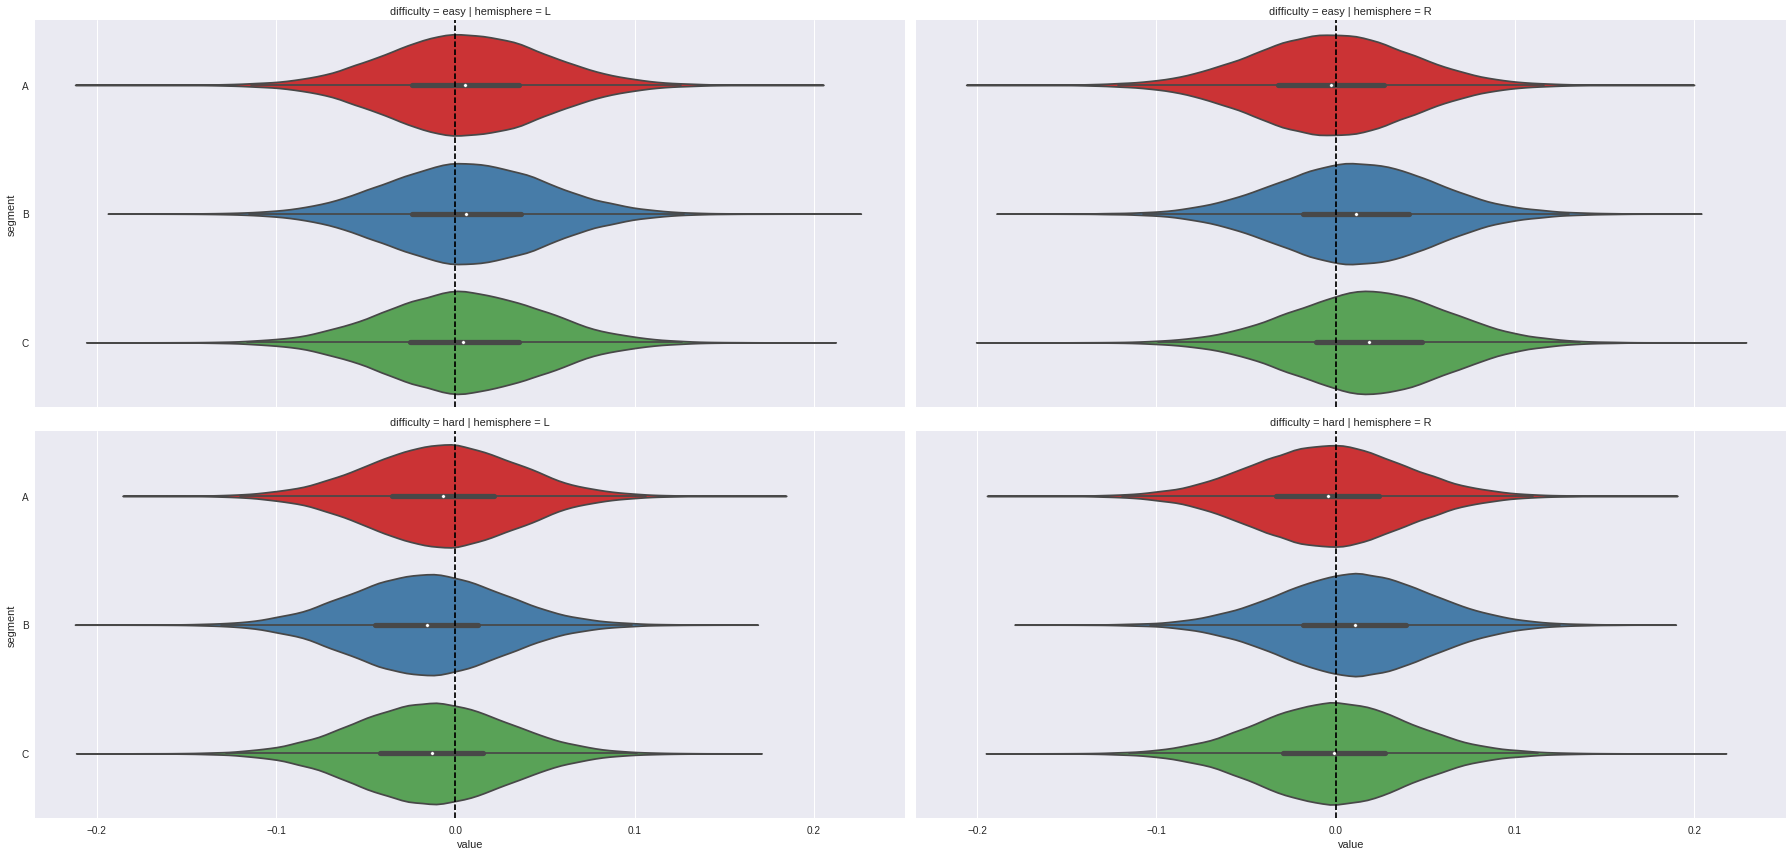

In [30]:
fac = sns.FacetGrid(df, col='hemisphere', row='difficulty')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')
    

fac.fig.set_size_inches(25, 12)
plt.tight_layout()

# Start point

In [32]:
results = []

for hemisphere in ['L', 'R']:
    for segment in ['A', 'B', 'C']:
        
        model = get_model('final_super_model_startpoint_group_zscored_STh_%s_%s' % (hemisphere, segment), 'L')
        traces = model.get_traces()

        tmp = pandas.DataFrame({'value':traces['z_cue_coding:STh_{hemisphere}_{segment}_cue'.format(**locals())],
                          'segment':segment,
                          'hemisphere':hemisphere})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_B_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_B_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [33]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  segment
L           A          0.945733
            B          0.880650
            C          0.854750
R           A          0.921283
            B          0.660750
            C          0.922200
dtype: float64

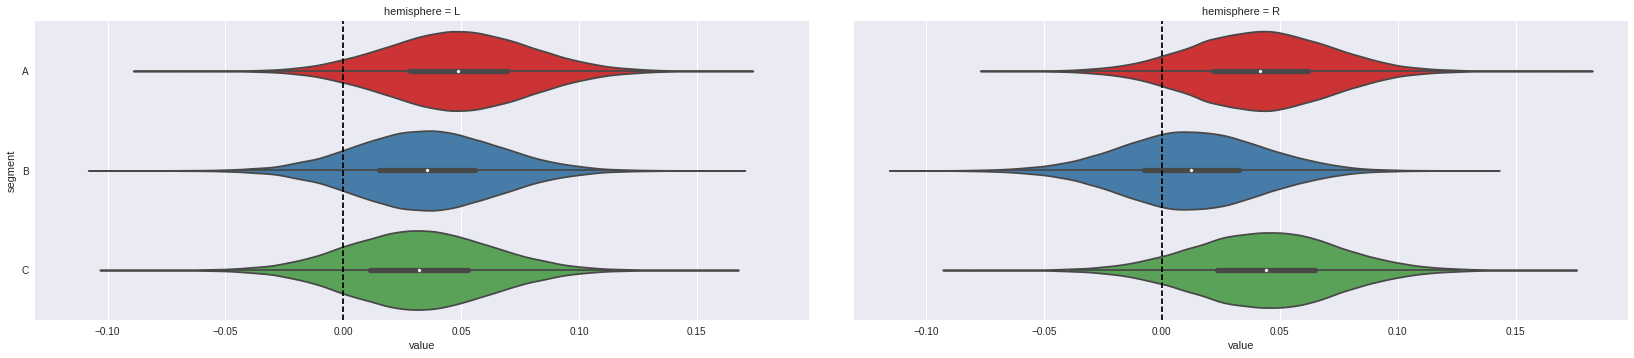

In [34]:
fac = sns.FacetGrid(df, col='hemisphere')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')


fac.fig.set_size_inches(25, 6)

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')